In [1]:
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from keras.models import Model, Sequential

def network(input_window_size=60, filter_number=32, conv_window=(3,), pooling_window=(2,), dropout_rate=[],
            activation='relu', dense_activation='softmax', optimizer='adam', loss='categorical_crossentropy', layers=1):
    model = Sequential()
    
    # Input Layer
    model.add(Conv1D(filter_number, conv_window, activation=activation, padding='same', input_shape=(input_window_size, 1)))
    model.add(MaxPooling1D(pooling_window, padding='same'))
    model.add(Dropout(dropout_rate[0]))

    
    # Hidden Layers
    current_filter = 1
    filter_number_temp = filter_number
    for i in range(layers):
        filter_number_temp = filter_number_temp *  2
        model.add(Conv1D(filter_number_temp, conv_window, activation=activation, padding='same'))
        model.add(MaxPooling1D(pooling_window, padding='same'))
        model.add(Dropout(dropout_rate[current_filter]))
        current_filter = current_filter + 1
    
    # Output Layer
    model.add(Flatten())
    model.add(Dense(2, activation=dense_activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'categorical_accuracy'])

    return model

Using TensorFlow backend.


In [2]:
import os
import h5py
import numpy as np
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


def rolling_window(a, window, step_size, padding=True, copy=True):
    if copy:
        result = a.copy()
    else:
        result = a
    if padding:
        result = np.hstack((result, np.zeros(window)))
    shape = result.shape[:-1] + (result.shape[-1] - window + 1 - step_size, window)
    strides = result.strides + (result.strides[-1] * step_size,)
    return np.lib.stride_tricks.as_strided(result, shape=shape, strides=strides)


size = 60

base_path = '/home/irene/Documents/Datos-Tesis/Training_window_station_name'

total_files = len(os.listdir(base_path))
x_dataset = np.zeros(shape=(0, size))
y_dataset = np.zeros(shape=(0, 1))
count = 1
skipped = []
for file_path in os.listdir(base_path):
    current_index = 0
    
    h5f = h5py.File(os.path.join(base_path, file_path), 'r')
    
    x = rolling_window(h5f['normal'][:], size, 1)
    y = rolling_window(h5f['transformed'][:], size, 1)
    y = [[np.amax(array)] for array in y]

    x_dataset = np.vstack((x_dataset, x))
    y_dataset = np.vstack((y_dataset, y))
    
#     while current_index < len(h5f['normal'][:]):
#         if current_index + size > len(h5f['normal'][:]):
#             difference = len(h5f['normal'][:]) - current_index
#             x = h5f['normal'][current_index:current_index+difference]
#             y = h5f['transformed'][current_index:current_index+difference]
#             difference2 = size - difference
#             x = np.append(x, np.zeros(difference2))
#             y = [np.amax(y)]
#         else:
#             x = h5f['normal'][current_index:current_index+size]
#             y = h5f['transformed'][current_index:current_index+size]
#             y = [np.amax(y)]

#         x_dataset = np.vstack((x_dataset, x))
#         y_dataset = np.vstack((y_dataset, y))
        
#         current_index = current_index + 1
    
    print(count)
    count = count + 1

x_dataset = np.reshape(x_dataset, (len(x_dataset), size, 1))
y_dataset = np.reshape(y_dataset, (len(y_dataset), 1))
y_dataset = to_categorical(y_dataset)

indices = np.arange(x_dataset.shape[0])
np.random.shuffle(indices)
x_dataset= x_dataset[indices] 
y_dataset= y_dataset[indices]

x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset)

num_to_load = len(x_dataset)
# split = int(num_to_load * 0.85)
split = int(num_to_load * 0.75)


# x_train = x_dataset[0:split]
# y_train = y_dataset[0:split]
# x_test = x_dataset[split:]
# y_test = y_dataset[split:]
    
# classifier.save_weights('/home/irene/Documents/Datos-Tesis/weights.h5')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152


In [3]:
# {'activation': 'relu', 'batch_size': 120, 'conv_window': (5,), 'dense_activation': 'softmax', '
# dropout_rate': array([0.13186719, 0.02294735, 0.11868113, 0.02764115, 0.08998026]), 'epochs': 58, 
# 'filter_number': 29, 'input_window_size': 60, 'layers': 4, 'loss': 'categorical_crossentropy', 
# 'optimizer': 'adam', 'pooling_window': (2,)}

cnn = network(input_window_size=60, filter_number=29, conv_window=(5,), pooling_window=(2,), 
              dropout_rate= [0.2, 0.1, 0.15, 0.1, 0.1],
              activation='relu', dense_activation='sigmoid', optimizer='adam', loss='binary_crossentropy', 
              layers=4)
cnn.fit(x_train, y_train, epochs=29, batch_size=120)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/29
114114/114114 [==============================] - 185s 2ms/step - loss: 0.1866 - acc: 0.9483 - categorical_accuracy: 0.9482
Epoch 2/29
114114/114114 [==============================] - 170s 1ms/step - loss: 0.1569 - acc: 0.9564 - categorical_accuracy: 0.9564
Epoch 3/29
114114/114114 [==============================] - 197s 2ms/step - loss: 0.1468 - acc: 0.9584 - categorical_accuracy: 0.9584
Epoch 4/29
114114/114114 [==============================] - 172s 2ms/step - loss: 0.1376 - acc: 0.9604 - categorical_accuracy: 0.9604
Epoch 5/29
114114/114114 [==============================] - 184s 2ms/step - loss: 0.1295 - acc: 0.9618 - categorical_accuracy: 0.9619
Epoch 6/29
114114/114114 [==============================] - 185s 2ms/step - loss: 0.1192 - acc:

In [4]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.core import read, UTCDateTime
from obspy.io.sac.util import get_sac_reftime
from obspy.signal.filter import lowpass, bandpass, highpass
import datetime


def picker_p_predict(file):
    p_is_defined = False
    tr = read(file)[0]

    tr.filter('bandpass', freqmin=1.0, freqmax=10.0, corners=4, zerophase=True)
    tr.normalize()
    if 'a' in tr.stats.sac and tr.stats.sac.a is not None: 
        picker_p = int(tr.stats.sac.a * tr.stats.sampling_rate)
        p_is_defined = True

    data = tr.data

    size = 60
    
    input_dataset = rolling_window(tr.data, size, 1)

    
#     input_dataset = np.zeros(shape=(0, size))
#     current_index = 0

#     while current_index < len(data):
#         if current_index + size > len(data):
#             difference = len(data) - current_index
#             x = data[current_index:current_index+difference]
#             difference2 = size - difference
#             x = np.append(x, np.zeros(difference2))
#         else:
#             x = data[current_index:current_index+size]

#         input_dataset = np.vstack((input_dataset, x))

#         current_index = current_index + 1
        
#         print(current_indexpic)

    input_dataset = np.reshape(input_dataset, (len(input_dataset), size, 1))
    output = [x[1] for x in cnn.predict(input_dataset)]
    output_running_mean = running_mean(output, size)
    guess = np.argmax(output_running_mean)


    plt.figure(figsize=(50,10))
#     plt.plot(data)
    plt.plot(tr.times(), data)

    if p_is_defined:
        plt.axvline(x=(picker_p*tr.stats.delta) , color='red')
        print("picker_p:", picker_p)
        
    plt.axvline(x=(guess*tr.stats.delta) , color='green', drawstyle ="steps-pre") 
    print("guess:", guess)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

#     plt.show()
    datetime_object = datetime.datetime.now()
    print(datetime_object)
    plt.savefig('/home/irene/Documents/Resultados/'+tr.stats.station+'_'+datetime_object.strftime('%m-%d-%Y::%H-%M')+'.png')

In [6]:
import os 

base_path = '/home/irene/Documents/Datos-Tesis/Estaciones/'

file = os.path.join(base_path, '/home/irene/Documents/Datos-Tesis/Estaciones/BATAN.HHZ.2018.337.16.57.18.sac')

print(file)
# picker_p_predict()

/home/irene/Documents/Datos-Tesis/Estaciones/BATAN.HHZ.2018.337.16.57.18.sac


guess: 20885
2019-05-10 21:31:04.067211


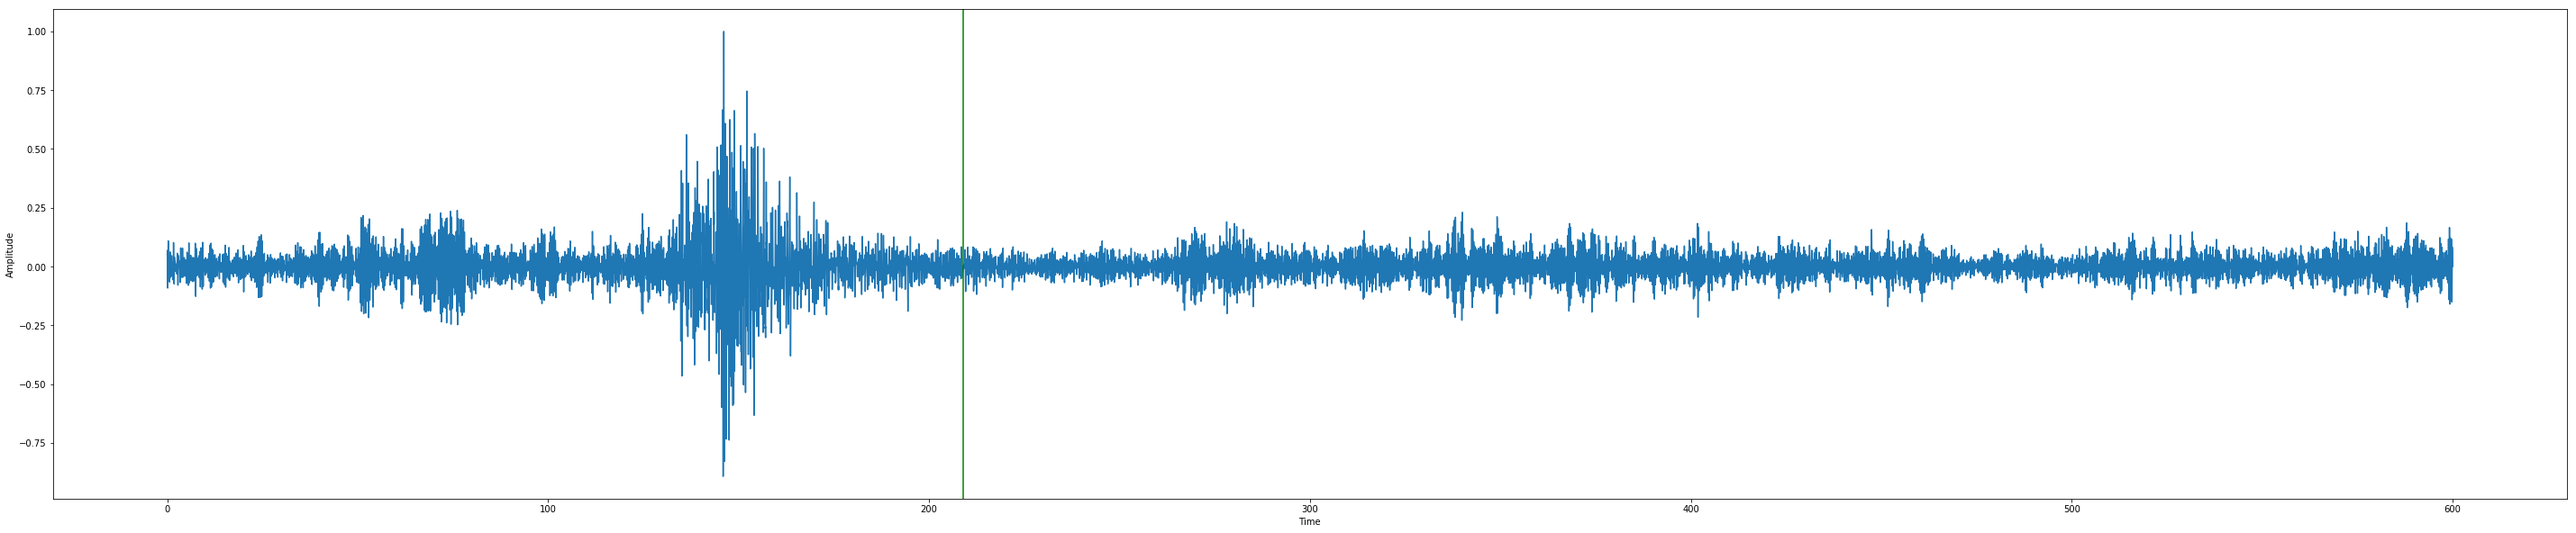

In [7]:
picker_p_predict(file)